In [1]:
%matplotlib inline

In [2]:
# importing libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import export_graphviz
import itertools
import graphviz

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.utils import np_utils
from keras import regularizers

Using TensorFlow backend.


In [4]:
np.random.seed(2)

## Ici on enlève les exemples pour lesquels la modalité de stalk-root est '?', on enlève la variable odeur qui selon l'étude préliminaire est jugée importante (plus de 70% d'importance dans l'arbre de décision).

In [5]:
# Read data from file
df = pd.read_csv("mushrooms.csv")

In [6]:
##################################### Information about data ##################################
# data shape (8124 examples, 23 comlumns)
df.shape

(8124, 23)

In [7]:
# Modalities in class column: 2 classes poisonous 'p' or edible 'e'
df["class"].unique()

array(['p', 'e'], dtype=object)

In [8]:
# We have missing values for stalk-root feature coded as '?'. Let's check their numbers
df[df['stalk-root'] == '?'].shape[0]

2480

In [9]:
print("{} % of values are missing".format(round((df[df['stalk-root'] == '?'].shape[0]/df.shape[0])*100, 2)))

30.53 % of values are missing


In [10]:
# On enlève les exemples où stalk-root = ?
df = df[df['stalk-root'] != '?']
df.shape

(5644, 23)

In [11]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [12]:
# on enlève la variable odeur
df = df.drop(labels = 'odor', axis =1)
df.shape

(5644, 22)

e    3488
p    2156
Name: class, dtype: int64

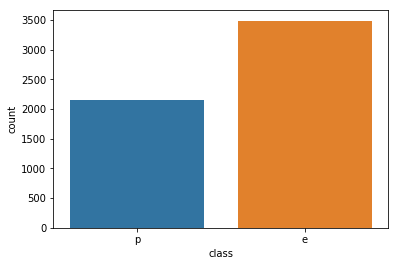

In [13]:
# On vérifie la distribution des deux classes : 61% comestibles 49% vénéneux
g = sns.countplot(df["class"])
df["class"].value_counts()

In [14]:
############################ Pré traitement des données ###################################################
# Encoding : class p = 1 et e = 0, one hot encoding pour les variables explicatives
df["class"] = LabelEncoder().fit_transform(df["class"])
df_Features = pd.get_dummies(df.loc[:, df.columns != "class"])
data = pd.concat([df["class"],df_Features ], axis=1)
data.head()

,class,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,...,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u
0,1,0,0,0,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [15]:
# Spilt data: 80% training 20% test
train, test = train_test_split(data, test_size=0.2)

0    2783
1    1732
Name: class, dtype: int64

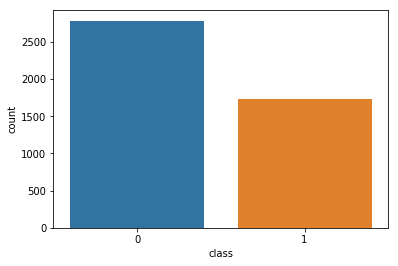

In [16]:
# Get responses of training
Y_train = train["class"]
# Get features of training
X_train = train.drop(labels = ["class"],axis = 1) 
Ytrain_distribution = sns.countplot(Y_train)
Y_train.value_counts()

0    705
1    424
Name: class, dtype: int64

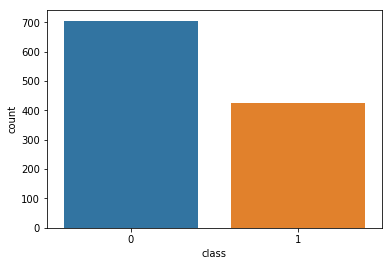

In [17]:
# Get responses of test
Y_test = test["class"]
# Get features of test
X_test = test.drop(labels = ["class"],axis = 1) 
Ytest_distribution = sns.countplot(Y_test)
Y_test.value_counts()

In [18]:
# Définfitions de quelques fonctions utiles

In [19]:
def model_metrics(y_true, y_pred):
    """ cette fonction retourne l'accuracy du modèle et l'air sous la courbe ROC"""
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    print(" Accuracy du modèle = {0} \t air sous la courbe ROC {1}".format(accuracy, auc))
    return

In [20]:
def plot_Roc(y_true, y_pred):
    """ Cette fonction plot la courbe ROC """
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_pred)
    plt.figure(figsize=(10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.3f'%auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return 

In [21]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix',cmap=plt.cm.Blues):
    """ Cette fonction plot la matrice de confusion    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)



    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel('True label')
    plt.ylabel('Predicted label')

## Premier modèle : Régression logistique avec pénalité L2 (Ridge) 

In [22]:
res_Log = LogisticRegression()
res_Log.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [23]:
res_Log.score(X_test, Y_test)

1.0

In [24]:
# model 1 metrics
preds = res_Log.predict(X_test)
model_metrics(Y_test, preds)

 Accuracy du modèle = 1.0 	 air sous la courbe ROC 1.0


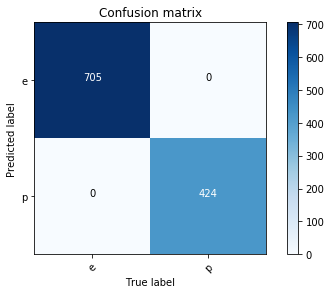

In [25]:
confusion_mtx = confusion_matrix(Y_test.values, preds).T
plot_confusion_matrix(confusion_mtx, classes = ('e','p'))

### 100% de bonnes classifications

In [26]:
# Avec penalité L1
model = LogisticRegression(penalty='l1')
model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [27]:
model.score(X_test, Y_test)

1.0

In [28]:
pred_model = model.predict(X_test)
model_metrics(Y_test, pred_model)

 Accuracy du modèle = 1.0 	 air sous la courbe ROC 1.0


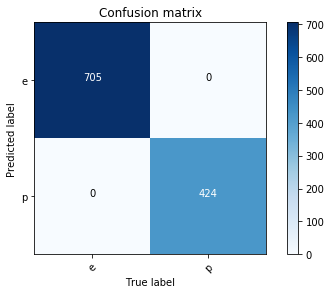

In [29]:
conf_mtx = confusion_matrix(Y_test.values, pred_model).T
plot_confusion_matrix(conf_mtx, classes = ('e','p'))

### 100% de bonnes classifications

## Troisième modèle : SVM avec noyau linéaire

In [30]:
svml = SVC(kernel='linear')
svml.fit(X_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [31]:
svml.score(X_test, Y_test)

1.0

In [32]:
predl = svml.predict(X_test)
model_metrics(Y_test, predl)

 Accuracy du modèle = 1.0 	 air sous la courbe ROC 1.0


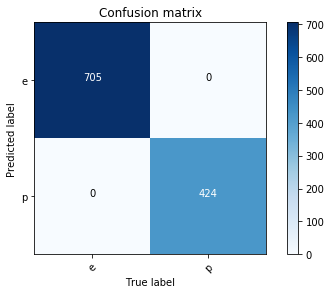

In [33]:
mat_conf = confusion_matrix(Y_test.values, predl).T
plot_confusion_matrix(mat_conf, classes = ('e','p'))

### 100% de bonne classification avec un noyau linéaire. On n'a pas besoin de tester des noyaux plus sophistiqués

## Quatrième modèle : Forêt aléatoire

In [34]:
RF = RandomForestClassifier()
RF.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [35]:
RF.score(X_test, Y_test)

1.0

In [36]:
predrf = RF.predict(X_test)
model_metrics(Y_test, predrf)

 Accuracy du modèle = 1.0 	 air sous la courbe ROC 1.0


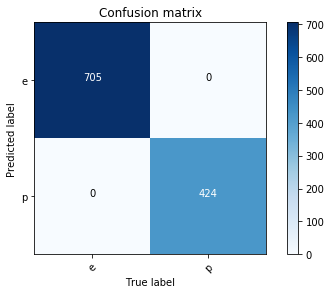

In [37]:
matrice_conf = confusion_matrix(Y_test.values, predrf).T
plot_confusion_matrix(matrice_conf, classes = ('e','p'))

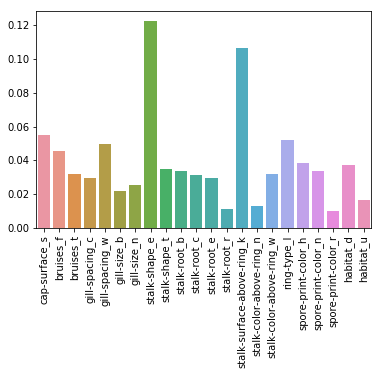

In [38]:
importance = RF.feature_importances_
plot = sns.barplot(x=df_Features.columns[importance>=0.01], y=importance[importance>=0.01])

for item in plot.get_xticklabels():
    item.set_rotation(90)

### Contrairement aux arbres de décisions l'importance des variables explicatives n'est pas limitée à 3 variables mais à plusieurs

## Cinquième modèle : Réseau de neurones
### Comme nous l'avons vu précédement des modèles simples ne font pas d'erreurs de prédiction. Faire un réseau de neurones est inutile

In [39]:
def neural_net(input_shape):
    model = Sequential()
    model.add(Dense(61, input_dim=input_shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [40]:
def train(model, x, y):
    k = model.fit(x=x, y=y, validation_split=0.2, batch_size= 20, epochs=100, verbose=0)
    return k

In [41]:
def score(model, x_test, y_test):
    score = model.evaluate(x_test, y_test)
    return score[1]

In [42]:
ann = neural_net(X_train.shape)
app = train(ann, X_train, Y_train)

In [43]:
score(ann, X_test, Y_test)

1129/1129 [==============================] - 0s 51us/step


1.0

In [44]:
prednn = np.around(ann.predict(X_test))

In [45]:
model_metrics(Y_test, prednn)

 Accuracy du modèle = 1.0 	 air sous la courbe ROC 1.0


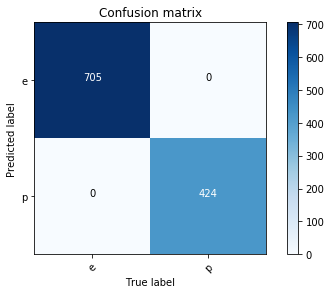

In [46]:
mc = confusion_matrix(Y_test.values, prednn).T
plot_confusion_matrix(mc, classes = ('e','p'))